# NTU Intro to AI/ML Presenation - Code

### Task

Reproduce code from GitHub based on chosen topic. 

### Chosen topic: 3. Diabetes Dataset
1. Official URL: [PIMA Indians Diabetes Dataset](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)
2. Suggested Tasks: predict diabetes onset, identify key predictors, or 
perform risk analysis and so on.


#### Sources: 
1. [Source GitHub](https://github.com/steve-zeyu-zhang/DiabetesDiagnosis.git)
2. [Base Paper](https://arxiv.org/abs/2403.07483)

In [72]:
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 
import numpy as np

# For Data Preprocessing 

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.utils import resample

# For Machine Learing Models 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

# For reporting on the machine learning models 

from sklearn.metrics import classification_report


import tensorflow as tf
from tensorflow import keras

import shap


## Loading the data using Pandas

We load the data into a datafram using the pandas module.

In [73]:
df = pd.read_csv('../data/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Data Visualisation and Preprocessing 

The data preprocessing fuctions are in the following cells. Steps used for data preprocessing

In [74]:
def data_split(data):
    
    X = data.iloc[:,:-1]
    y = data.iloc[:,-1]
    
    train_x, test_x, train_y, test_y = train_test_split(X,y,test_size = 0.2, random_state=0)

    return train_x, test_x, train_y, test_y

def data_scaling(train_x, test_x):

    ss = StandardScaler()
    ss_model = ss.fit(train_x)
    train_x_scaled = ss_model.transform(train_x)
    test_x_scaled = ss_model.transform(test_x)

    return train_x_scaled, test_x_scaled


def data_scaling_plot(data):
    X = data.iloc[:,:-1].to_numpy()
    y = data.iloc[:,-1].to_numpy()

    ss = StandardScaler()
    ss_model = ss.fit(X)
    X_scaled = ss_model.transform(X)
    np_new = np.hstack((X_scaled, y.reshape(len(y),1)))
    column_headers = data.columns.values.tolist()
    df_new = pd.DataFrame(data = np_new, columns = column_headers)
    
    return df_new

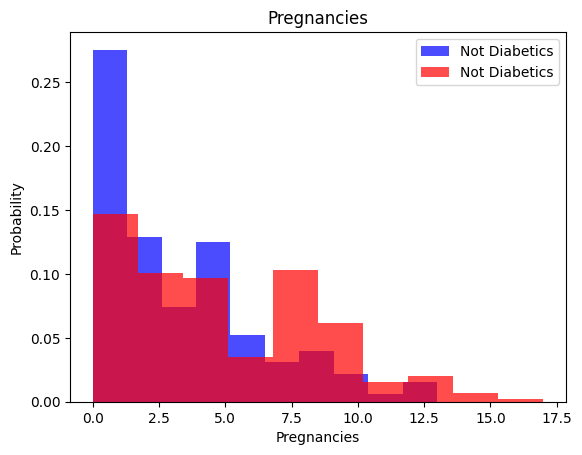

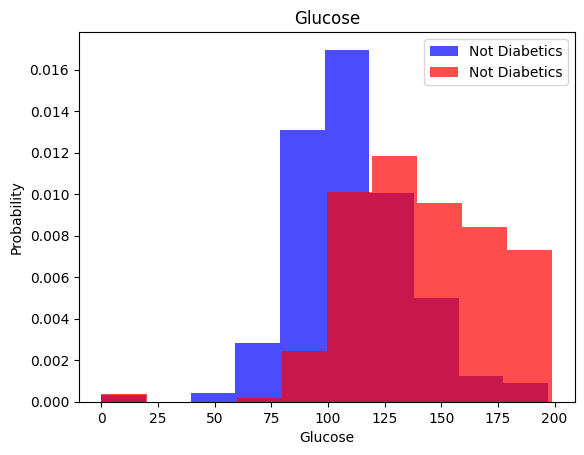

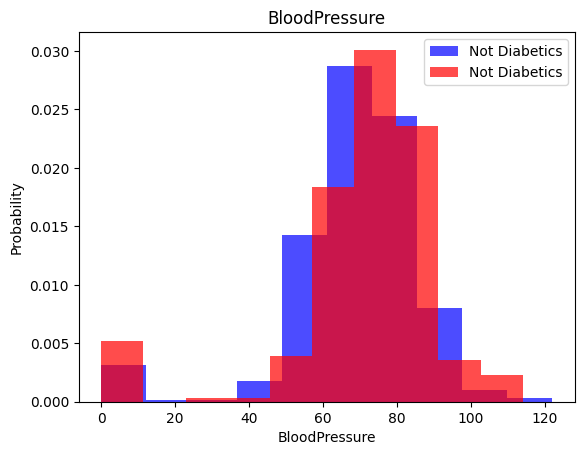

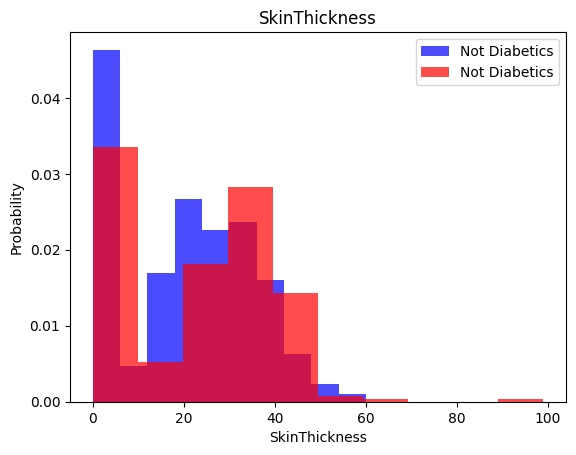

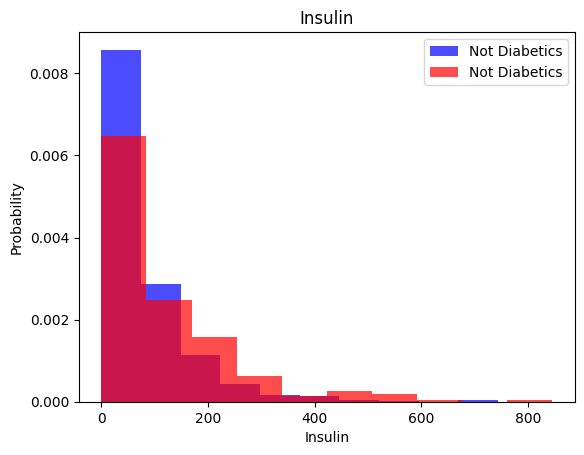

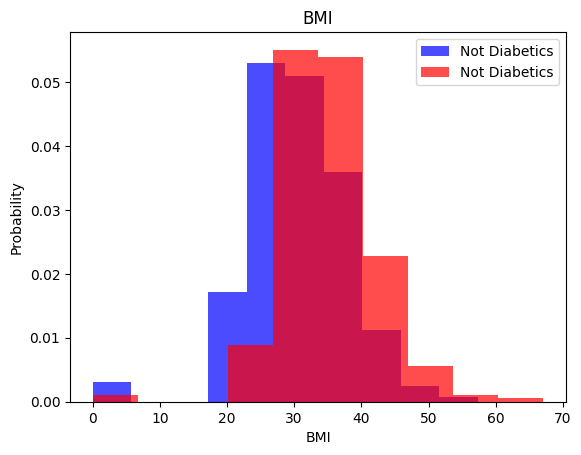

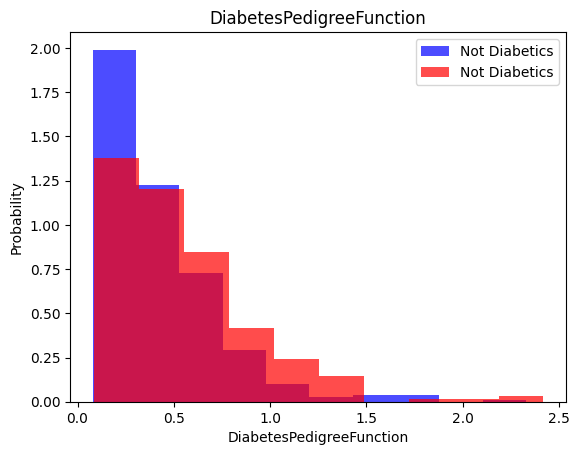

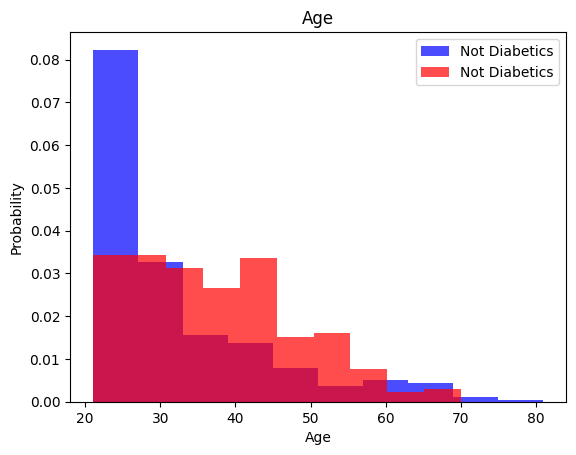

In [200]:
for label in df.columns[0:-1]:
    plt.hist(df[df["Outcome"]==0][label], color = 'blue', label='Not Diabetics', alpha=0.7, density=True)
    plt.hist(df[df["Outcome"]==1][label], color = 'red', label='Not Diabetics', alpha=0.7, density=True)
    plt.title(label)
    plt.ylabel("Probability")
    plt.xlabel(label)
    plt.legend()
    plt.show()

In [202]:
print('Class 0:', (df.iloc[ :, -1] == 0).sum())
print('Class 1:', (df.iloc[ :, -1] == 1).sum())


Class 0: 500
Class 1: 268


In [76]:
def undersample(df):
  #create two different dataframe of majority and minority class 
  if ((df.iloc[:,-1] == 0).sum()) >= ((df.iloc[:,-1] == 1).sum()):
    df_majority = df[(df.iloc[:,-1] == 0)] 
    df_minority = df[(df.iloc[:,-1] == 1)]
    n_minor = (df.iloc[:,-1] == 1).sum()
  else:
    df_majority = df[(df.iloc[:,-1] == 1)] 
    df_minority = df[(df.iloc[:,-1] == 0)]
    n_minor = (df.iloc[:,-1] == 0).sum()   
  
  # oversample minority class
  df_majority_undersample = resample(df_majority, 
                                  replace=True,    # sample with replacement
                                  n_samples= n_minor, # to match minority class
                                  random_state=42)  # reproducible results
  # Combine
  resample_df = pd.concat([df_majority_undersample, df_minority])

  # Shuffle
  resample_df = resample_df.sample(frac=1, random_state=1).reset_index(drop=True)

  return resample_df

### KNN

In [189]:
def knn_cv(df,n,size, markersize):
    train_x, test_x, train_y, test_y = data_split(df)
    train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)
    #-------------------------
    # find the optimal K
    # create a validation set
    
    
    best_k = -1
    best_score = -1
    for k in [1,2,3,5,7,9,15,31,51]:
        knn = KNeighborsClassifier(n_neighbors=k)    # just change the n_neighbors parameter
        
        cv_result = cross_validate(knn, train_x_scaled, train_y, cv=n ,scoring='accuracy',n_jobs=-1, return_train_score = True)
        train_score = np.mean(cv_result['train_score'])
        val_score = np.mean(cv_result['test_score'])
        
        knn_model = knn.fit(train_x_scaled, train_y) # scaled X, un-scaled y
        print("k:", k, "Training Score:", train_score, "Validation Score: ", val_score)
        # find the best k
        if best_score <= val_score:
            best_score = val_score
            best_model = knn_model
            best_k = k
    
    explainer_knn = shap.KernelExplainer(knn.predict, train_x_scaled)
    shap_values = explainer_knn.shap_values(test_x_scaled)

    test_y_pred = best_model.predict(test_x_scaled)
    tn, fp, fn, tp = confusion_matrix(test_y, test_y_pred).ravel()
    print(f'The best k is {best_k} and the best val score is {best_score:.4f}')


    print(classification_report(test_y, test_y_pred))

    shap.summary_plot(shap_values, test_x_scaled, feature_names=df.columns[:-1])



### Logistic Regression

In [127]:
def lg(df,k,size, markersize):
    train_x, test_x, train_y, test_y = data_split(df)
    train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

    mdl = LogisticRegressionCV(cv=k, multi_class='ovr', random_state=0).fit(train_x_scaled, train_y)
    
    test_y_pred = mdl.predict(test_x_scaled)
    tn, fp, fn, tp = confusion_matrix(test_y, test_y_pred).ravel()

    explainer_mdl = shap.Explainer(mdl, train_x_scaled)
    shap_val = explainer_mdl(test_x_scaled)

    print(classification_report(test_y, test_y_pred))

    shap.summary_plot(shap_val,test_x_scaled, feature_names=df.columns[:-1])



### SVM

In [145]:
def svm(df,n,size, markersize):
  train_x, test_x, train_y, test_y = data_split(df)
  train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)
  mdl = SVC(kernel='linear')
  
  cv_result = cross_validate(mdl, train_x_scaled, train_y, cv=n ,scoring='accuracy',n_jobs=-1, return_train_score = True)
  train_score = np.mean(cv_result['train_score'])
  val_score = np.mean(cv_result['test_score'])
  
  mdl.fit(train_x_scaled, train_y)

  test_y_pred = mdl.predict(test_x_scaled)


  explainer_svm = shap.KernelExplainer(mdl.predict, train_x_scaled)
  shap_values = explainer_svm.shap_values(test_x_scaled)

  shap.summary_plot(shap_values ,test_x_scaled, feature_names=df.columns[:-1])

  print(classification_report(test_y, test_y_pred))



### Decision Trees

In [170]:
def tree_cv(df, k, size, markersize):
  # Data Spliting
  train_x, test_x, train_y, test_y = data_split(df)
  train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)


  # Create a hyperparameters_dict
  hyperparameters_dict = {'max_depth': range(2,20,2),
                    'min_samples_split': range(2, 20, 2), 
                    'min_samples_leaf': range(2, 20, 2) }

  # Grid Search with 5 cross fold validation
  best_score = -1
  best_parameter = {'max_depth': 0,
                    'min_samples_split': 0, 
                    'min_samples_leaf': 0 }

  for max_depth in hyperparameters_dict['max_depth']:
      for min_samples_split in hyperparameters_dict['min_samples_split']:
          for min_samples_leaf in hyperparameters_dict['min_samples_leaf']:
              dt = DecisionTreeClassifier(max_depth=max_depth, 
                                          min_samples_split=min_samples_split, 
                                          min_samples_leaf=min_samples_leaf)
              # 5 cross fold validation
              scores = cross_validate(dt, train_x_scaled, train_y, cv=k ,scoring='accuracy',n_jobs=-1)['test_score']
              mean_score = np.mean(scores)
              if mean_score > best_score:
                  best_parameter['max_depth'] = max_depth
                  best_parameter['min_samples_split'] = min_samples_split
                  best_parameter['min_samples_leaf'] = min_samples_leaf
                  best_score = mean_score
              
                  
  print(f'the best model parameter: {best_parameter} and the best mean accuracy: {best_score:.4f}')

  # Apply best hyperparameters (best model) to visualise the decision tree

  dt_best = DecisionTreeClassifier(**best_parameter)
  dt_best_model = dt_best.fit(train_x_scaled, train_y)

  test_y_pred = dt_best_model.predict(test_x_scaled)


  print(classification_report(test_y, test_y_pred))



### Random Forest Classifier

In [185]:
def forest(df, k, size, markersize):
  train_x, test_x, train_y, test_y = data_split(df)
  train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

  forest_mdl = RandomForestClassifier(max_depth=2, random_state=0)
  forest_mdl.fit(train_x_scaled, train_y)

  test_y_pred = forest_mdl.predict(test_x_scaled)



  print(classification_report(test_y, test_y_pred))



### XGBoost 

In [141]:
def xgboost_cv(df):
  train_x, test_x, train_y, test_y = data_split(df)
  train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

  mdl = XGBClassifier()
  mdl.fit(train_x_scaled, train_y)

  test_y_pred = mdl.predict(test_x_scaled)

  print(classification_report(test_y, test_y_pred))




In [147]:
def adaboost(df, k, size, markersize):
    train_x, test_x, train_y, test_y = data_split(df)
    train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

    # Define the base model (Decision Tree)
    base_model = DecisionTreeClassifier(max_depth=1)  # Decision stump

    # Define the AdaBoost model
    adaboost_mdl = AdaBoostClassifier(estimator=base_model, random_state=0)

    # Define the parameter grid
    param_grid = {
        'n_estimators': [10, 50, 100],
        'learning_rate': [0.01, 0.1, 1]
    }

    # Perform Grid Search with cross-validation using k folds
    grid_search = GridSearchCV(estimator=adaboost_mdl, param_grid=param_grid, cv=k, scoring='accuracy', n_jobs=-1, return_train_score=True)
    grid_search.fit(train_x_scaled, train_y)

    best_model = grid_search.best_estimator_

    best_model.fit(train_x_scaled, train_y)
    test_y_pred = best_model.predict(test_x_scaled)

    print(classification_report(test_y, test_y_pred))



In [84]:
# Read 'NIDDK_Pima.csv'
niddk_df = pd.read_csv("../data/diabetes.csv")

# Drop NaN value
print("Any null value:", any(niddk_df.isnull()))
print("Any NaN value:", any(niddk_df.isna()))
print("Before Droping NaN Number of Rows:", len(niddk_df))

niddk_df = niddk_df.dropna()
print("After Droping NaN Number of Rows:", len(niddk_df))

niddk_df.tail()

Any null value: True
Any NaN value: True
Before Droping NaN Number of Rows: 768
After Droping NaN Number of Rows: 768


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


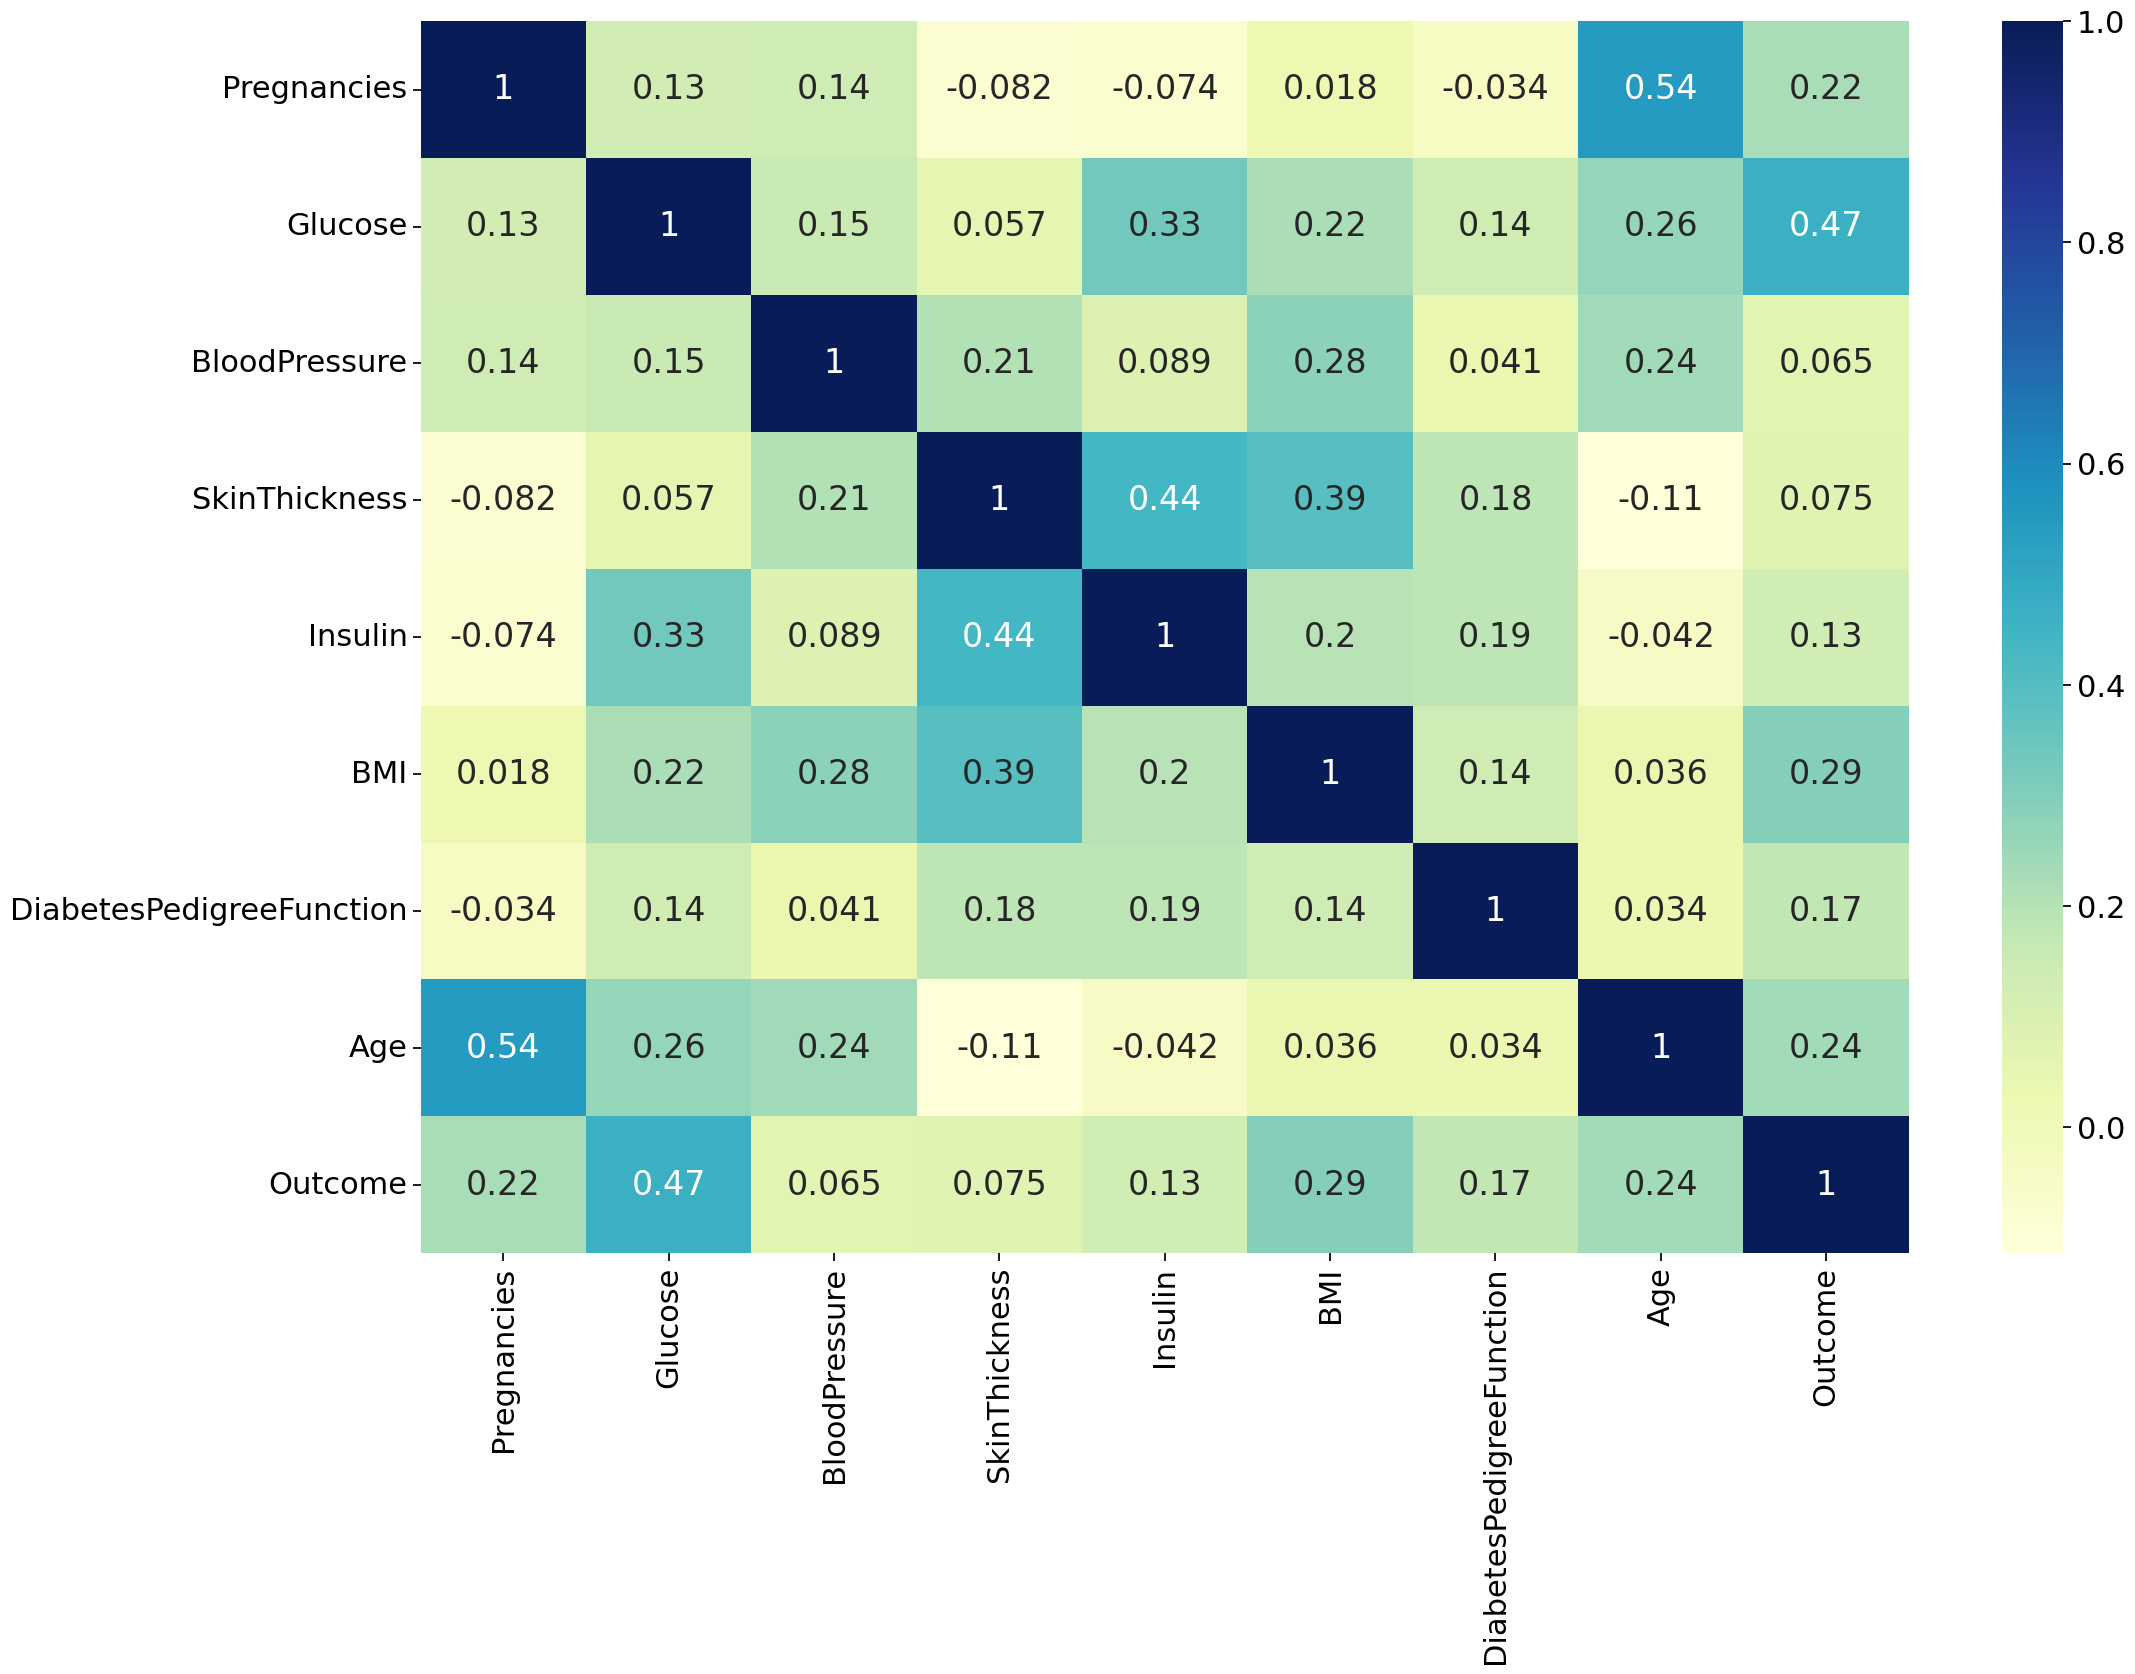

In [85]:
corrMatrix = niddk_df.corr()

# Generate a heatmap
plt.figure(figsize=[24,16])
with sns.plotting_context("notebook",font_scale=2):
  sns.heatmap(corrMatrix, cmap="YlGnBu", annot=True)

In [86]:
niddk_df = undersample(niddk_df)
checkNum(niddk_df)

Class 0: 268
Class 1: 268


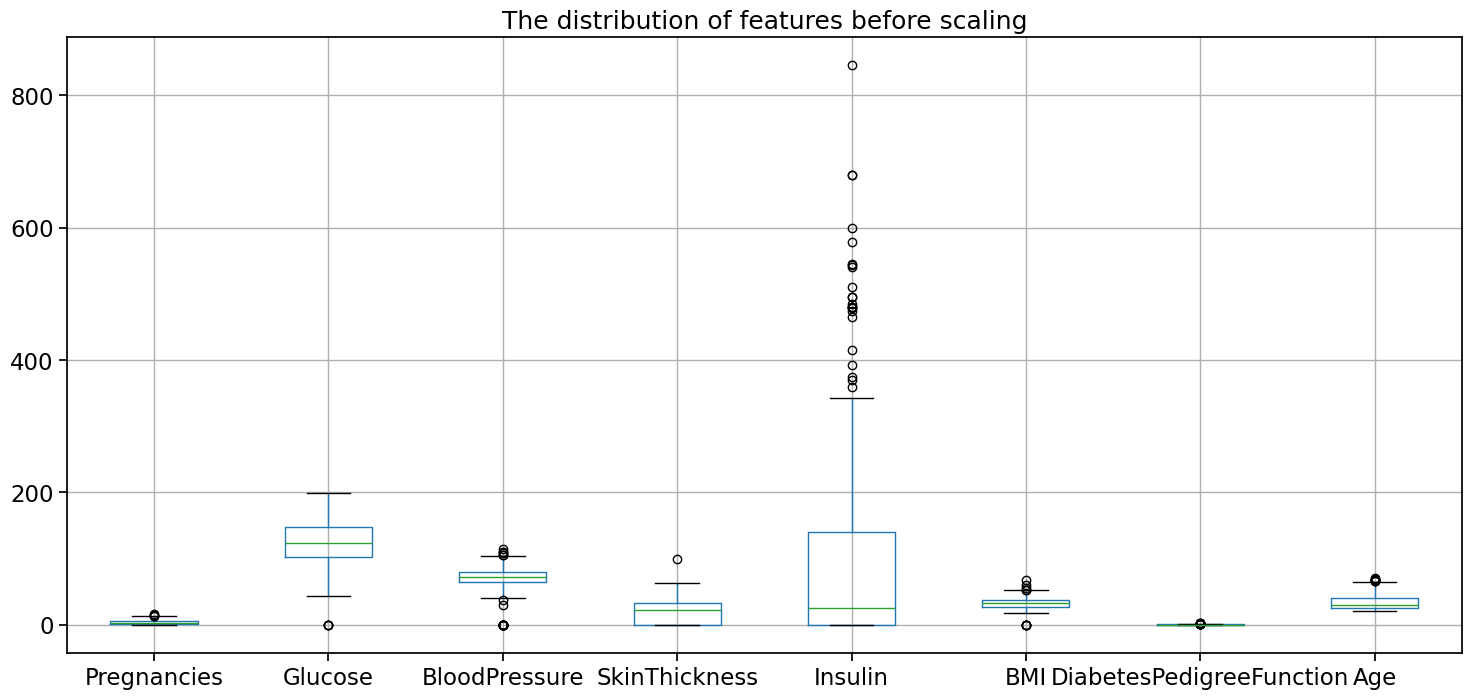

In [87]:
plt.figure(figsize=[18,8])
with sns.plotting_context("notebook",font_scale=1.5):
  niddk_df.boxplot(column=niddk_df.columns.values.tolist()[:-1])
  plt.title("The distribution of features before scaling")

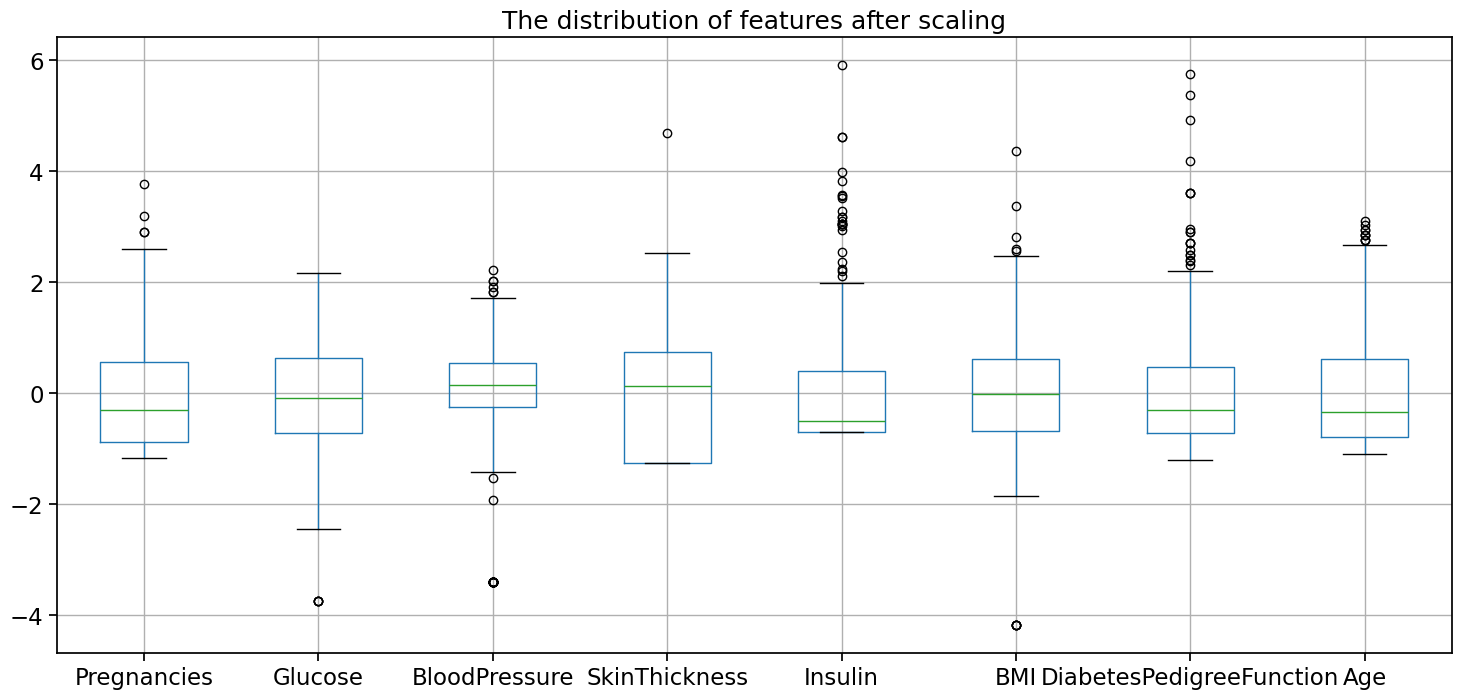

In [88]:
plt.figure(figsize=[18,8])
with sns.plotting_context("notebook",font_scale=1.5):
  data_scaling_plot(niddk_df).boxplot(column=niddk_df.columns.values.tolist()[:-1])
  plt.title("The distribution of features after scaling")

k: 1 Training Score: 1.0 Validation Score:  0.7452530779753762
k: 2 Training Score: 0.8323649259202428 Validation Score:  0.7147469220246239
k: 3 Training Score: 0.856305730312175 Validation Score:  0.7148837209302326
k: 5 Training Score: 0.8043049801374182 Validation Score:  0.6962517099863201
k: 7 Training Score: 0.7885444904778953 Validation Score:  0.693953488372093
k: 9 Training Score: 0.7681022283600156 Validation Score:  0.6938714090287278
k: 15 Training Score: 0.7552367312839923 Validation Score:  0.7101778385772913
k: 31 Training Score: 0.7248836376655926 Validation Score:  0.7080164158686731


Using 428 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


k: 51 Training Score: 0.7213816855062828 Validation Score:  0.7079890560875512


100%|██████████| 108/108 [04:13<00:00,  2.35s/it]

The best k is 1 and the best val score is 0.7453
              precision    recall  f1-score   support

           0       0.75      0.72      0.74        54
           1       0.73      0.76      0.75        54

    accuracy                           0.74       108
   macro avg       0.74      0.74      0.74       108
weighted avg       0.74      0.74      0.74       108



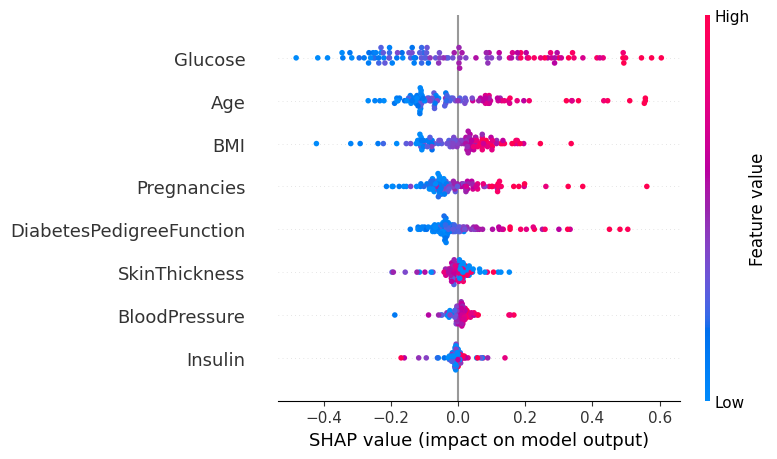

In [190]:
knn_cv(niddk_df, 5, 100, 1)

              precision    recall  f1-score   support

           0       0.76      0.76      0.76        54
           1       0.76      0.76      0.76        54

    accuracy                           0.76       108
   macro avg       0.76      0.76      0.76       108
weighted avg       0.76      0.76      0.76       108



/Users/rudrakshsrivastava/Programming/NTU-Team-Research/code/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


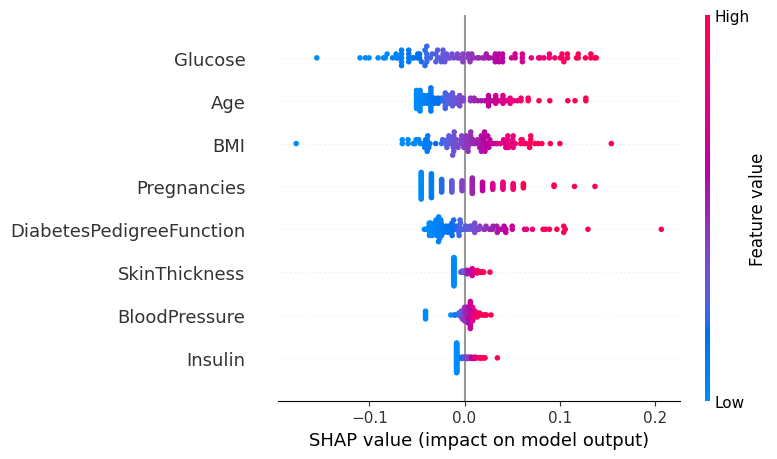

In [218]:
lg(niddk_df,5, 100, 1)

Using 428 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 108/108 [00:53<00:00,  2.02it/s]


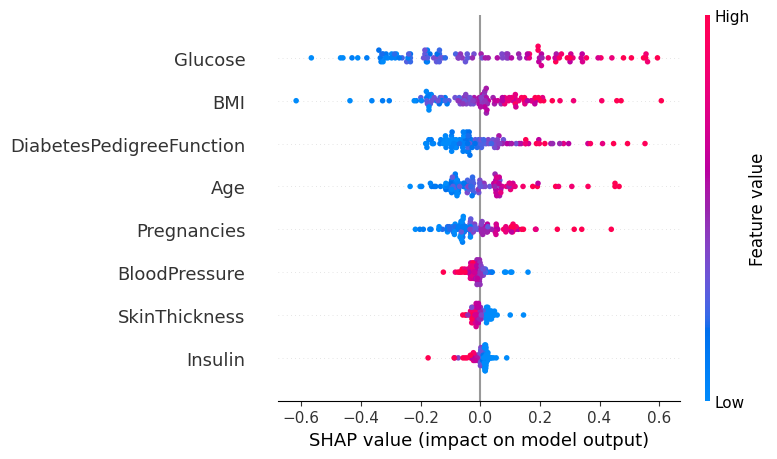

              precision    recall  f1-score   support

           0       0.79      0.78      0.79        54
           1       0.78      0.80      0.79        54

    accuracy                           0.79       108
   macro avg       0.79      0.79      0.79       108
weighted avg       0.79      0.79      0.79       108



In [136]:
svm(niddk_df,5, 100, 1)

In [171]:
tree_cv(niddk_df,5, 100, 1)

the best model parameter: {'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 6} and the best mean accuracy: 0.7313
              precision    recall  f1-score   support

           0       0.73      0.91      0.81        54
           1       0.88      0.67      0.76        54

    accuracy                           0.79       108
   macro avg       0.80      0.79      0.78       108
weighted avg       0.80      0.79      0.78       108



In [186]:
forest(niddk_df,5, 100, 1)

              precision    recall  f1-score   support

           0       0.81      0.63      0.71        54
           1       0.70      0.85      0.77        54

    accuracy                           0.74       108
   macro avg       0.75      0.74      0.74       108
weighted avg       0.75      0.74      0.74       108



In [142]:
xgboost_cv(niddk_df)

              precision    recall  f1-score   support

           0       0.87      0.87      0.87        54
           1       0.87      0.87      0.87        54

    accuracy                           0.87       108
   macro avg       0.87      0.87      0.87       108
weighted avg       0.87      0.87      0.87       108



In [148]:
adaboost(df, 5, 100, 1)

/Users/rudrakshsrivastava/Programming/NTU-Team-Research/code/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/rudrakshsrivastava/Programming/NTU-Team-Research/code/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/rudrakshsrivastava/Programming/NTU-Team-Research/code/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/rudrakshsrivastava/Programming/NTU-Team-Research/code/lib/python3.12/site-packages/sklearn/ensemble/_weight_boo

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       107
           1       0.70      0.60      0.64        47

    accuracy                           0.80       154
   macro avg       0.77      0.74      0.75       154
weighted avg       0.79      0.80      0.79       154



/Users/rudrakshsrivastava/Programming/NTU-Team-Research/code/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_213 (Dense)               │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_214 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_215 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_216 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


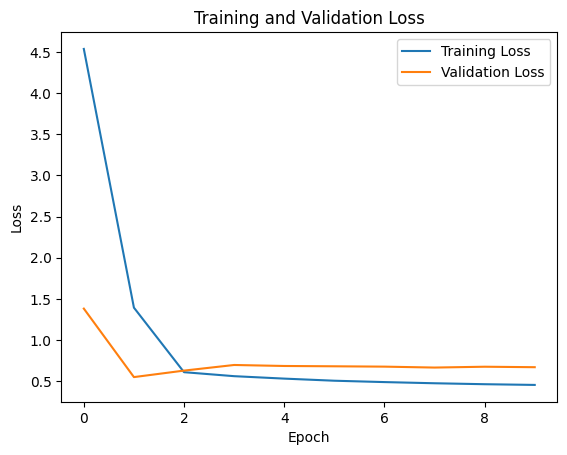

0.8181818181818182


In [238]:
from keras.models import Sequential
from keras.layers import Dense, Input

train_x, test_x, train_y, test_y = data_split(df)
train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

# Define the Sequential model
model = Sequential()

# Add the first layer with Input(shape)
model.add(Input(shape=(train_x_scaled.shape[1],)))

model.add(Dense(64, activation='relu'))

model.add(Dense(32, activation='relu'))

model.add(Dense(16, activation='relu'))

model.add(Dense(1, activation='relu'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

history = model.fit(train_x_scaled, train_y, epochs=10, batch_size=16, validation_split=0.2, verbose=0)
preds = (model.predict(test_x_scaled) > 0.5).astype(int)

accuracy = accuracy_score(test_y, preds)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(accuracy)

Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_229 (Dense)               │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_230 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_231 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_232 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


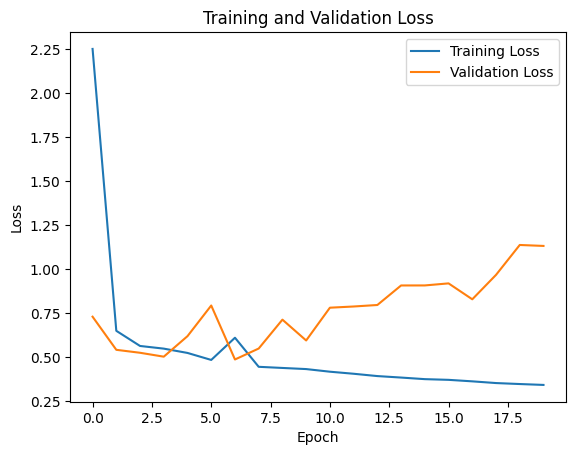

0.8246753246753247


In [242]:
train_x, test_x, train_y, test_y = data_split(df)
train_x_scaled, test_x_scaled = data_scaling(train_x, test_x)

# Define the Sequential model
model = Sequential()

# Add the first layer with Input(shape)
model.add(Input(shape=(train_x_scaled.shape[1],)))

model.add(Dense(64, activation='relu'))

model.add(Dense(32, activation='relu'))

model.add(Dense(16, activation='relu'))

model.add(Dense(1, activation='relu'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

history = model.fit(train_x_scaled, train_y, epochs=20, batch_size=16, validation_split=0.2, verbose=0)
preds = (model.predict(test_x_scaled) > 0.5).astype(int)

accuracy = accuracy_score(test_y, preds)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(accuracy)

Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_302 (Dense)               │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_303 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_304 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_305 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,649 (14.25 KB)

 Trainable params: 3,425 (13.38 KB)

 Non-trainable params: 224 (896.00 B)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.8448 - loss: 0.4325
Test Accuracy: 0.8116883039474487


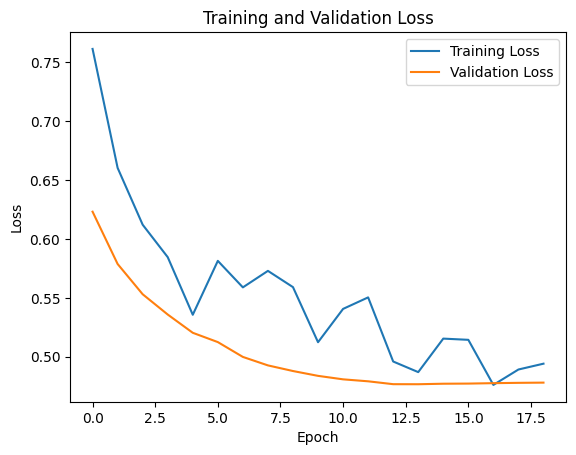

In [261]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the Sequential model
model = Sequential()

# Add the first layer with Input(shape)
model.add(Input(shape=(train_x_scaled.shape[1],)))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())  # Add batch normalization layer
model.add(Dropout(0.2))  # Add dropout layer

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())  # Add batch normalization layer
model.add(Dropout(0.2))  # Add dropout layer

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())  # Add batch normalization layer
model.add(Dropout(0.2))  # Add dropout layer

model.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' for binary classification

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Define the optimizer with a fixed learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Define callbacks for early stopping and learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * 0.9 ** epoch)  # Learning rate decay

# Train the model
history = model.fit(train_x_scaled, train_y, epochs=100, batch_size=16, validation_split=0.2, 
                    callbacks=[early_stopping, lr_schedule], verbose=0)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_x_scaled, test_y)
print(f"Test Accuracy: {test_accuracy}")

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
